In [1]:
#Nhập dữ liệu 
import pandas as pd
from datetime import datetime
dataset=pd.read_excel('ecommerce retail.xlsx',sheet_name='ecommerce retail')

In [2]:
#Loại CustomerID trống và các đơn có Quantity <=0 ra khỏi bảng
dataset_clean=dataset.query('Quantity>0 and CustomerID.notnull()')

In [3]:
#Đổi Data Type của InvoiceDate
dataset_used=dataset_clean.astype({"InvoiceDate":"datetime64[ns]",'CustomerID':'int64'})

In [4]:
#Tính số tiền cho mỗi đơn hàng
dataset_used['Spending']=dataset_used['Quantity']*dataset_used['UnitPrice']

In [5]:
dataset_used.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spending
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [6]:
#Sử dụng Groupby để tính ngày mua cuối cùng, số lượng đơn mua, số tiền bỏ ra ở mỗi khách hàng. Bảng này gọi là x
x=dataset_used.groupby('CustomerID', as_index=False).agg({'InvoiceDate':max,'InvoiceNo':'nunique','Spending':sum})

In [7]:
#Tính khoảng cách từ ngày mua cuối cùng tới ngày 31/12/2011 - Recency
x['DateDiff']=(datetime(2011,12,31)-x['InvoiceDate']).dt.days

In [8]:
#Tính điểm recency 
x['R_score']=pd.qcut(x['DateDiff'],5,labels=[5,4,3,2,1])

In [9]:
#Tính điểm Frequency
x['F_score']=pd.qcut(x['InvoiceNo'].rank(method='first'),5,labels=[1,2,3,4,5])

In [10]:
#Tính điểm Monetary
x['M_score']=pd.qcut(x['Spending'].rank(method='first'),5,labels=[1,2,3,4,5])

In [12]:
#Đổi tên một số cột trong bảng x
x.rename(columns={'InvoiceNo':'Frequency','DateDiff':'Recency','Spending':'Monetary'},inplace=True)

In [13]:
#Tính điểm RFM
x['RFM Score']=x['R_score'].astype(str)+x['F_score'].astype(str)+x['M_score'].astype(str)

,CustomerID,InvoiceDate,Frequency,Monetary,Recency,R_score,F_score,M_score,RFM Score
0,12346,2011-01-18 10:01:00,1,77183.60,346,1,1,5,115
1,12347,2011-12-07 15:52:00,7,4310.00,23,5,5,5,555
2,12348,2011-09-25 13:13:00,4,1797.24,96,2,4,4,244
3,12349,2011-11-21 09:51:00,1,1757.55,39,4,1,4,414
4,12350,2011-02-02 16:01:00,1,334.40,331,1,1,2,112


In [14]:
#Tạo bảng RFM final
RFM=x.iloc[:,[0,2,3,4,5,6,7,8]]
RFM.head()

,CustomerID,Frequency,Monetary,Recency,R_score,F_score,M_score,RFM Score
0,12346,1,77183.60,346,1,1,5,115
1,12347,7,4310.00,23,5,5,5,555
2,12348,4,1797.24,96,2,4,4,244
3,12349,1,1757.55,39,4,1,4,414
4,12350,1,334.40,331,1,1,2,112


In [15]:
#Nhập sheet segmentation trong file excel
segment=pd.read_excel('ecommerce retail.xlsx',sheet_name='Segmentation')

In [16]:
#Chuyển từ dạng string sang dạng list của các giá trị cột RFM Score
segment['RFM Score']=segment['RFM Score'].str.split(',')

In [17]:
#Chuyển chuỗi thành cột
segment_used=segment.explode('RFM Score')

In [18]:
#Lược bỏ các khoảng trắng trước và sau của RFM Score
segment_used['RFM Score']=segment_used['RFM Score'].str.strip()

In [19]:
#Left join với bảng RFM
RFM_Segmentation=RFM.merge(segment_used,on='RFM Score',how='left')

In [20]:
RFM_Segmentation.head()

,CustomerID,Frequency,Monetary,Recency,R_score,F_score,M_score,RFM Score,Segment
0,12346,1,77183.60,346,1,1,5,115,Cannot Lose Them
1,12347,7,4310.00,23,5,5,5,555,Champions
2,12348,4,1797.24,96,2,4,4,244,At Risk
3,12349,1,1757.55,39,4,1,4,414,Promising
4,12350,1,334.40,331,1,1,2,112,Lost customers


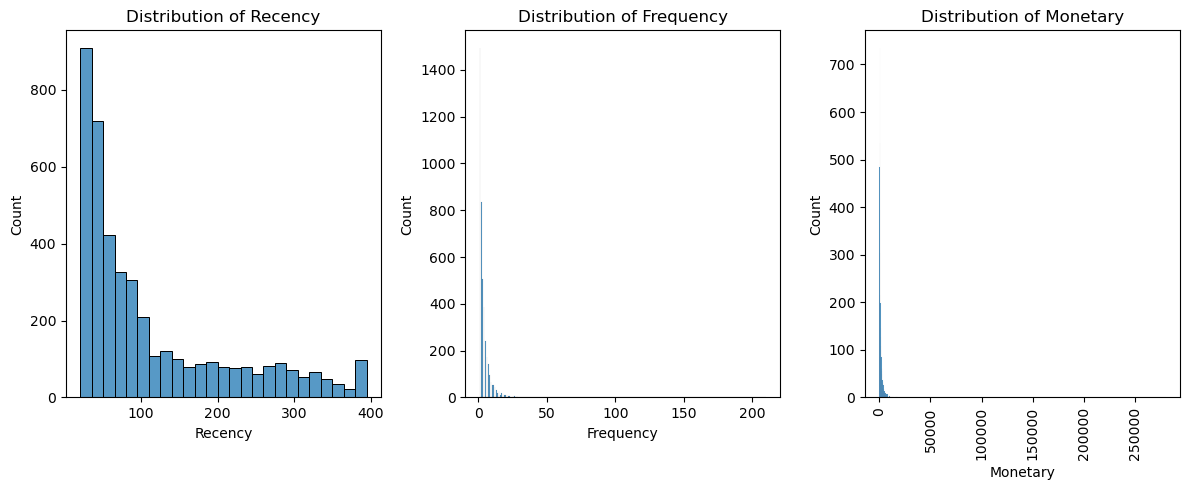

In [21]:
#Create histogram để biểu thị sự phân bổ của 3 yếu tố Recency, Frequency, Monetary
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs= plt.subplots(ncols=3,figsize=(12,5))
sns.histplot(RFM_Segmentation['Recency'],ax=axs[0])
axs[0].set_title('Distribution of Recency')
sns.histplot(RFM_Segmentation['Frequency'],ax=axs[1])
axs[1].set_title('Distribution of Frequency')
sns.histplot(RFM_Segmentation['Monetary'],ax=axs[2])
axs[2].set_title('Distribution of Monetary')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [22]:
#Group by để tính số khách hàng và số tiền theo mỗi segment
y=RFM_Segmentation.groupby('Segment',as_index=False).agg({'CustomerID':'count','Monetary':sum})

                  Segment  CustomerID     Monetary
0          About To Sleep         283    77885.540
1                 At Risk         423   752061.261
2        Cannot Lose Them          91   203671.300
3               Champions         835  5604376.680
4   Hibernating customers         695   285420.302
5          Lost customers         486    97405.610
6                   Loyal         428  1021224.390
7          Need Attention         281   463778.001
8           New Customers         268    59755.620
9      Potential Loyalist         413   224797.850
10              Promising         136   121031.350


In [36]:
#Tính % share của số lượng khách hàng và spending theo segment
y['Count_share']=y['CustomerID']*100/sum(y['CustomerID'])
y['Monetary_share']=y['Monetary']*100/sum(y['Monetary'])

                  Segment  CustomerID     Monetary  Count_share  \
0          About To Sleep         283    77885.540     6.522240   
1                 At Risk         423   752061.261     9.748790   
2        Cannot Lose Them          91   203671.300     2.097257   
3               Champions         835  5604376.680    19.244065   
4   Hibernating customers         695   285420.302    16.017516   
5          Lost customers         486    97405.610    11.200737   
6                   Loyal         428  1021224.390     9.864024   
7          Need Attention         281   463778.001     6.476147   
8           New Customers         268    59755.620     6.176538   
9      Potential Loyalist         413   224797.850     9.518322   
10              Promising         136   121031.350     3.134363   

    Monetary_share  
0         0.873998  
1         8.439309  
2         2.285512  
3        62.889913  
4         3.202864  
5         1.093044  
6        11.459742  
7         5.204318  
8     

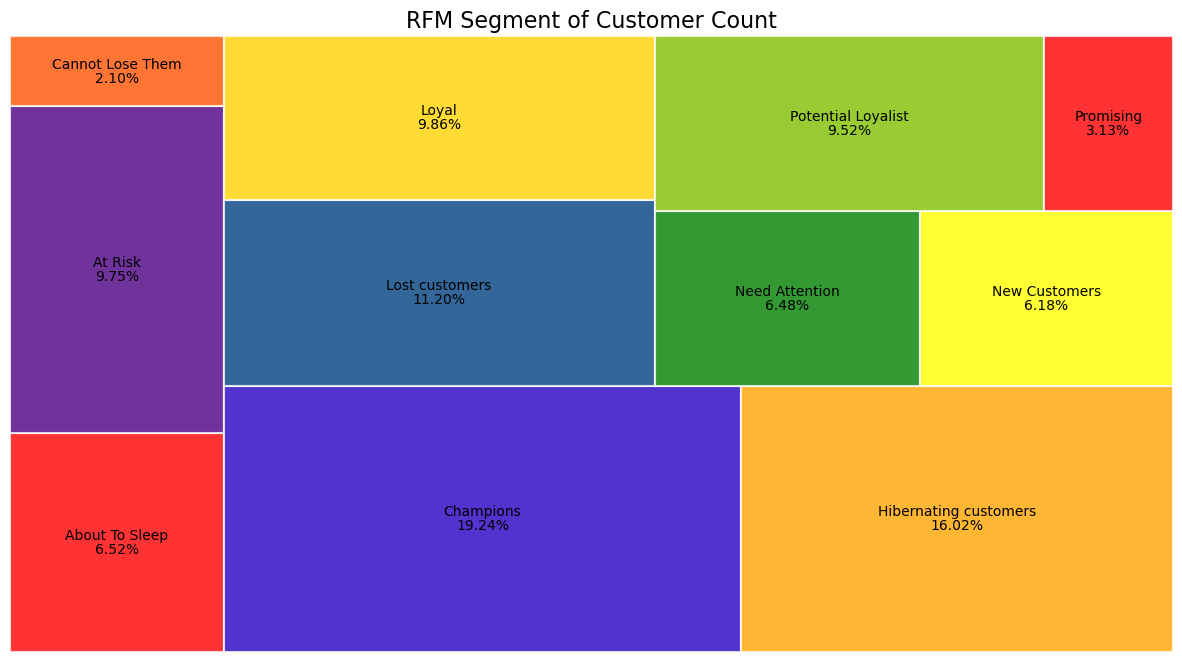

In [44]:
#Tạo treemap về tỉ lệ % số lượng khách hàng của từng segment
import squarify
colors=['#ff0000','#4b0082','#ff5300','#2600c1','#ffa500','#004080','#ffd200','#008000','#ffff00','#80c000']

fig,ax = plt.subplots(1,figsize=(15,8))

squarify.plot(sizes=y['CustomerID'],
                  label=y['Segment'],
                  value=[f'{x:.2f}%' for x in y['Count_share']],
                  alpha=.8,
                  color=colors,
                  bar_kwargs=dict(linewidth=1.5,edgecolor='white'))
plt.title('RFM Segment of Customer Count',fontsize=16)
plt.axis('off')
plt.show()
                  
                

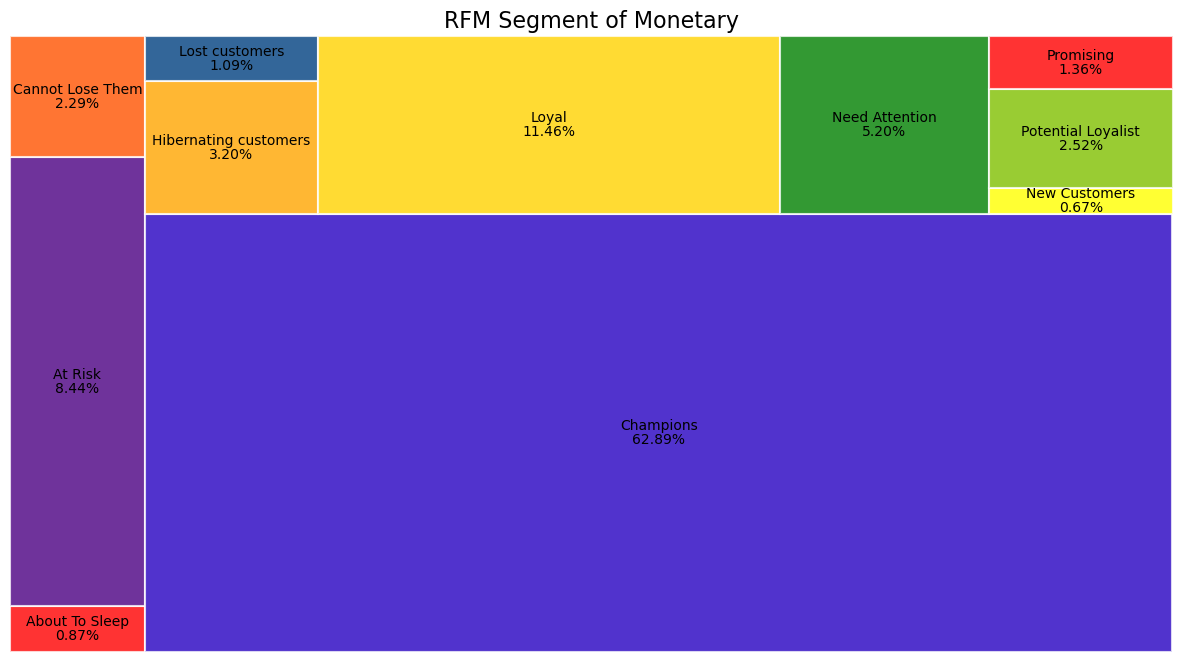

In [45]:
#Tạo treemap về tỉ lệ % monetarycủa từng segment
colors=['#ff0000','#4b0082','#ff5300','#2600c1','#ffa500','#004080','#ffd200','#008000','#ffff00','#80c000']

fig,ax = plt.subplots(1,figsize=(15,8))

squarify.plot(sizes=y['Monetary'],
                  label=y['Segment'],
                  value=[f'{x:.2f}%' for x in y['Monetary_share']],
                  alpha=.8,
                  color=colors,
                  bar_kwargs=dict(linewidth=1.5,edgecolor='white'))
plt.title('RFM Segment of Monetary',fontsize=16)
plt.axis('off')
plt.show()
            